# Produce dirty image and psf, from a (rascil) FITS image, and an instrumental setup (baselines, frequencies, etc.)

In [65]:
from visibilities import *
from images import *
import matplotlib.pyplot as plt
plt.set_loglevel("critical")
cmap='viridis'

### Define baseline configuration, integration time, hour angle interval of observations, phase centre, etc.

In [66]:
phasecentre = SkyCoord(ra=+56.0 * u.deg, dec=-30.0 * u.deg, frame='icrs', equinox='J2000')
ha_interval=(-2,2)
vt = generate_visibilities(phasecentre,ha_interval,tel="MEERKAT")

create_named_configuration: MEERKAT
	(<Quantity 5109360.08350152 m>, <Quantity 2006852.56658911 m>, <Quantity -3238948.21751511 m>)
	GeodeticLocation(lon=<Longitude 21.44388889 deg>, lat=<Latitude -30.7110565 deg>, height=<Quantity 1086.6 m>)
create_configuration_from_file: 64 antennas/stations


create_visibility: created 120 times
create_visibility: 249600 rows, 0.013 GB


### Plot uv coverage


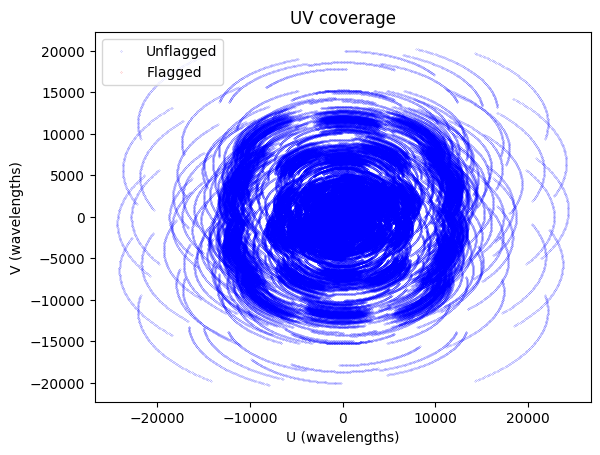

In [67]:
plot_uvcoverage([vt])
#plot_visibility([vt],y='amp')

### Fill visibilities amplitude from (Fourier plane values) of image in FITS file. Cell size corresponds to the (advised) pixel angular size in radians. Uses Nifty gridder.

In [68]:
vt, cell_size, im = visibilities_from_image(vt,'data/Meerkat_Galactic_center_512_ext.fits',return_cellsize=True,return_image=True)
#vt, cell_size, im = visibilities_from_image(vt,'data/toto_ext.fits',return_cellsize=True,return_image=True,scale_factor=1.)

advise_wide_field: (max_wavelength) Maximum wavelength 0.300 (meters)
advise_wide_field: (min_wavelength) Minimum wavelength 0.300 (meters)
advise_wide_field: (maximum_baseline) Maximum baseline 24331.5 (wavelengths)
advise_wide_field: (maximum_w) Maximum w 10597.6 (wavelengths)
advise_wide_field: (diameter) Station/dish diameter 13.5 (meters)
advise_wide_field: (primary_beam_fov) Primary beam 0.0222 (rad) 1.27 (deg) 4.58e+03 (asec)
advise_wide_field: (image_fov) Image field of view 0.0666 (rad) 3.82 (deg) 1.37e+04 (asec)
advise_wide_field: (synthesized_beam) Synthesized beam 4.11e-05 (rad) 0.00235 (deg) 8.48 (asec)
advise_wide_field: (cellsize) Cellsize 1.03e-05 (rad) 0.000589 (deg) 2.12 (asec)
advice_wide_field: (npixels) Npixels per side = 6484
advice_wide_field: (npixels2) Npixels (power of 2) per side = 8192
advice_wide_field: (npixels23) Npixels (power of 2, 3) per side = 8192
advice_wide_field: (npixels_min) Npixels (power of 2, 3, 4, 5) per side = 6561

advice_wide_field: (w_sa

### Export visibility data to measurement set file

In [70]:
from rascil.processing_components import export_visibility_to_ms
export_visibility_to_ms('data/Meerkat_Galactic_center.ms',[vt])

create_visibility_from_ms: {'type': 'Measurement Set', 'subType': '', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\n'}
create_visibility_from_ms: Reading unique fields [0], unique data descriptions [0]
create_visibility_from_ms: Found 249600 rows
create_visibility_from_ms: Found 1 channels
create_visibility_from_ms: Reading all 1 channels
create_visibility_from_ms: Observation from 2000-01-01 17:37:07.746 to 2000-01-01 21:35:07.746


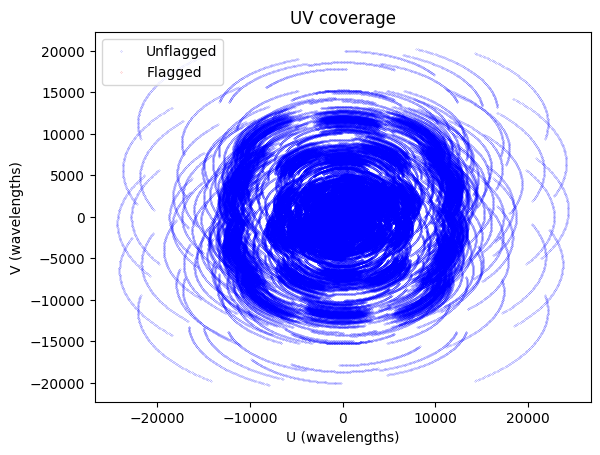

In [71]:
from rascil.processing_components import create_visibility_from_ms
[vv] = create_visibility_from_ms('data/Meerkat_Galactic_center.ms')
plot_uvcoverage([vv])

### Plot visibility amplitudes as a function of uv radius

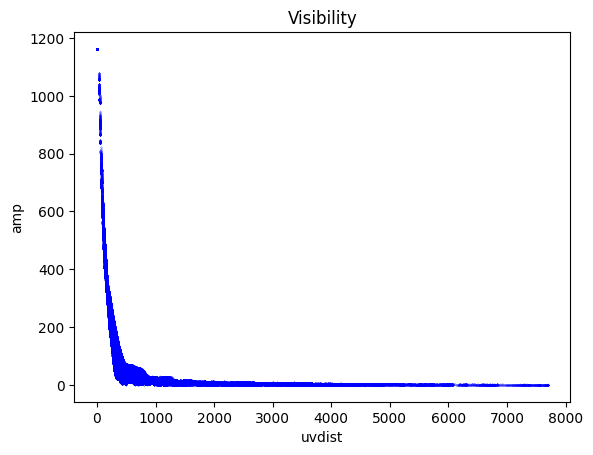

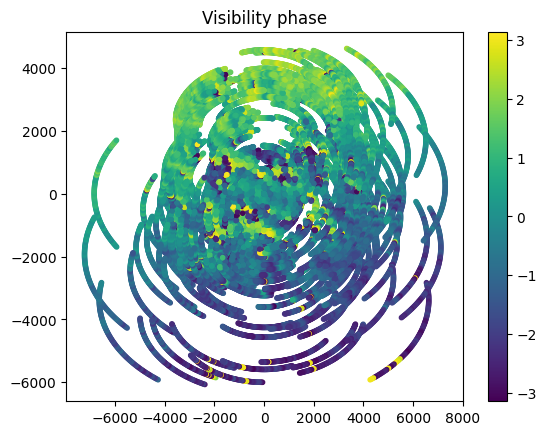

In [69]:
#vv = np.ones(vt.vis.shape)
#vt["vis"].data = vv

plot_visibility([vt])
u = vt.visibility_acc.u.data
v = vt.visibility_acc.v.data
c = np.angle(vt.visibility_acc.flagged_vis).flat

plt.title('Visibility phase')
plt.scatter(u,v,c=c,marker='.')
plt.colorbar()


### Create empty (rascil) image from visibility metadata. Then predict dirty and psf images using nifty gridder (adjoint)

In [72]:
dirty, psf = dirty_psf_from_visibilities(vv,cell_size,npix=512)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 24331.536075 wavelengths
create_image_from_visibility: Critical cellsize = 0.000021 radians, 0.001177 degrees
create_image_from_visibility: Cellsize = 1.02747e-05 radians, 0.000588699 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)
Model image plate scale (arcsec) is 2.119316e+00


### Visualize original image, dirty image and psf

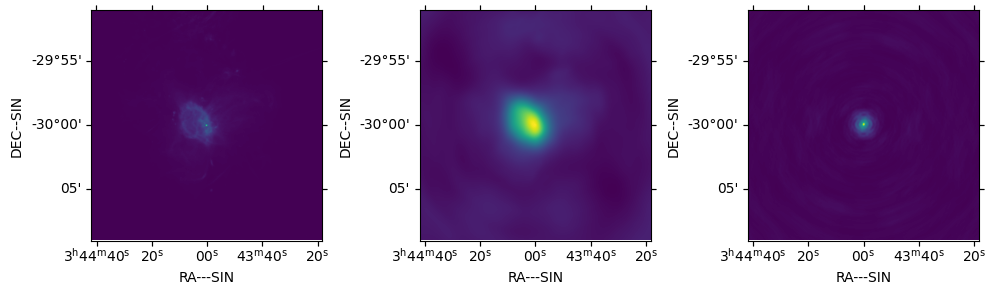

In [73]:
#show_image(im,cm=cmap)
#show_image(dirty,cm=cmap)
#show_image(psf,cm=cmap)
fig = plt.figure(figsize=(12,3))
ax=fig.add_subplot(1,3,1,projection=im.image_acc.wcs.sub([1, 2]))
ax.imshow(im.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(im.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(im.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,2,projection=dirty.image_acc.wcs.sub([1, 2]))
ax.imshow(dirty.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(dirty.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(dirty.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,3,projection=psf.image_acc.wcs.sub([1, 2]))
ax.imshow(psf.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(psf.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(psf.image_acc.wcs.wcs.ctype[1])



In [8]:
dirty.image_acc.export_to_fits('data/dirty_ps.fits')
psf.image_acc.export_to_fits('data/psf.fits')

(-0.05, 1.0)

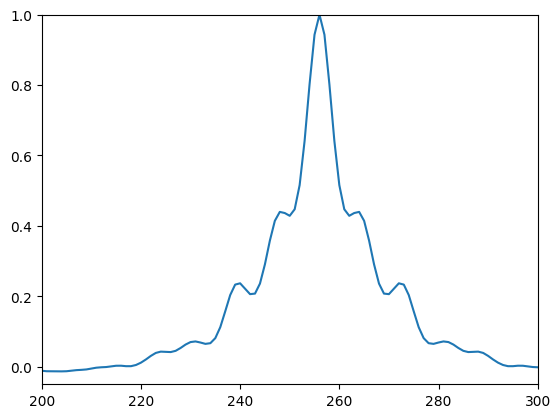

In [9]:
plt.plot(psf['pixels'].data[0,0,256,:])
plt.xlim((200,300)); plt.ylim((-0.05,1))

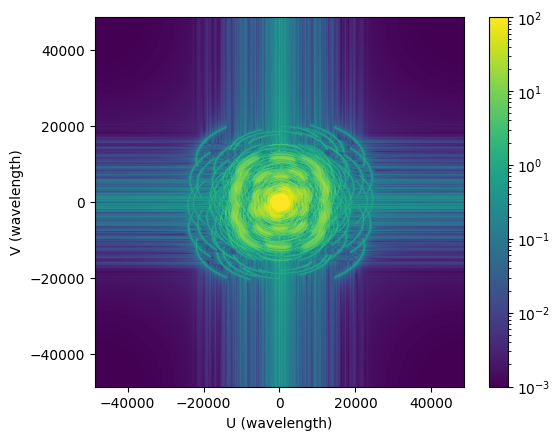

In [12]:
uv_psf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psf.pixels.data.squeeze())))
from matplotlib.colors import LogNorm
uv_size = 1./cell_size/2.
plt.imshow(np.abs(uv_psf),norm=LogNorm(vmin=0.001,vmax=100),extent=[-uv_size,uv_size,-uv_size,uv_size])
plt.xlabel('U (wavelength)')
plt.ylabel('V (wavelength)')
plt.colorbar()

In [13]:
from astropy.io import fits as pyfits
hdu = pyfits.PrimaryHDU(np.real(uv_psf))
hdu.writeto("uv_psf.fits",overwrite=True)

In [14]:
nrows,nbaselines, _ = vt.uvw.shape

In [15]:
uv=vt.visibility_acc.uvw_lambda[...,0:2]
uv = uv.reshape(nrows*nbaselines,2)

In [16]:
uv.shape

(249600, 2)

In [17]:
from scipy.spatial import KDTree
tree = KDTree(uv)
neighbors = tree.query_ball_tree(tree,r=100)

In [59]:
weights = 1./np.array([len(l) for l in neighbors])
weights /= np.sum(weights)
weights = weights.reshape(nrows,nbaselines,1,1)
vt.imaging_weight.data = weights


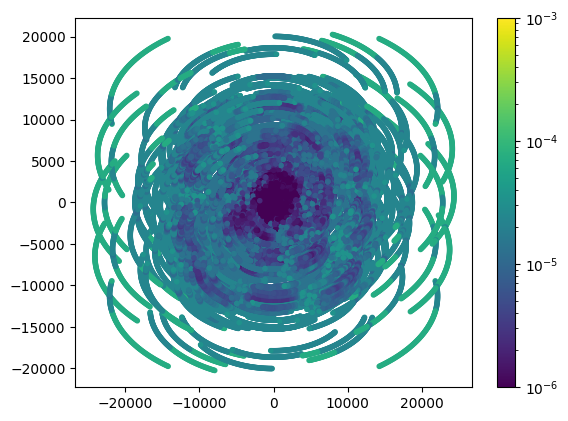

In [60]:
plt.scatter(uv[:,0],uv[:,1],c=weights,marker='.',norm=LogNorm(vmin=0.000001,vmax=0.001))
plt.scatter(-uv[:,0],-uv[:,1],c=weights,marker='.',norm=LogNorm(vmin=0.000001,vmax=0.001))
plt.colorbar()

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 24331.536075 wavelengths
create_image_from_visibility: Critical cellsize = 0.000021 radians, 0.001177 degrees
create_image_from_visibility: Cellsize = 1.02747e-05 radians, 0.000588699 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)
Model image plate scale (arcsec) is 2.119316e+00


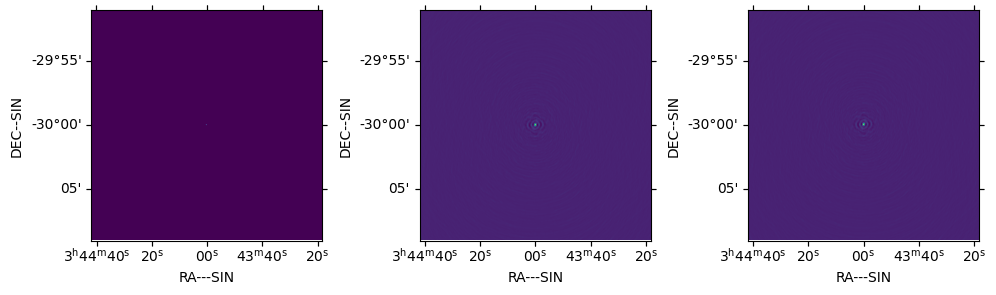

In [61]:
dirty, psf = dirty_psf_from_visibilities(vt,cell_size,npix=512)
fig = plt.figure(figsize=(12,3))
ax=fig.add_subplot(1,3,1,projection=im.image_acc.wcs.sub([1, 2]))
ax.imshow(im.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(im.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(im.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,2,projection=dirty.image_acc.wcs.sub([1, 2]))
ax.imshow(dirty.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(dirty.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(dirty.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,3,projection=psf.image_acc.wcs.sub([1, 2]))
ax.imshow(psf.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(psf.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(psf.image_acc.wcs.wcs.ctype[1])



(-0.1, 1.0)

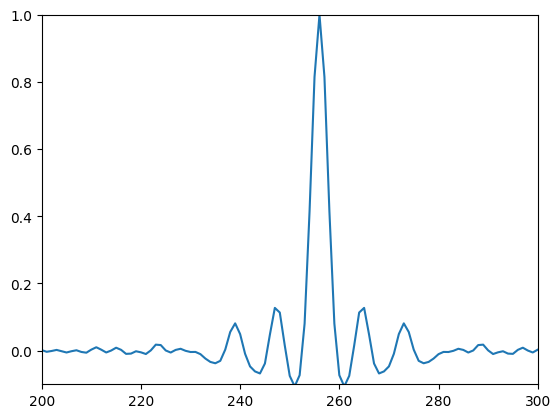

In [63]:
plt.plot(psf['pixels'].data[0,0,256,:])
plt.xlim((200,300)); plt.ylim((-0.1,1))

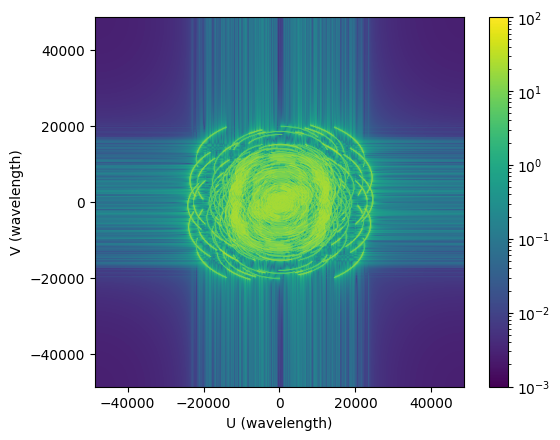

In [64]:
uv_psf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psf.pixels.data.squeeze())))
from matplotlib.colors import LogNorm
uv_size = 1./cell_size/2.
plt.imshow(np.abs(uv_psf),norm=LogNorm(vmin=0.001,vmax=100),extent=[-uv_size,uv_size,-uv_size,uv_size])
plt.xlabel('U (wavelength)')
plt.ylabel('V (wavelength)')
plt.colorbar()

In [75]:
cell_size

1.0274731493628636e-05